Autoencoder에 대한 기본 개념과 불균형한 데이터셋을 학습한 모델의 평가 방법을 설명하고, 신용카드 이상 거래를 탐지하는 Autoencoder 모델을 만들어봅니다.


  * 1. Autoencoder는 어떤 데이터의 입력을 받은 후, 정보를 압축시켰다가 다시 확장하며 입력받은 것과 최대한 비슷한 결과값을 반환하는 '재구성'의 방법을 통해 특정 데이터의 패턴을 인코딩합니다.
  * 2. 신용카드 거래 데이터셋은 대부분 정상 거래 데이터로 이루어져 있으며, 이상 거래 데이터는 적게 포함되어 있는 불균형한 데이터셋입니다.
  * 3. Autoencoder 모델을 정상 거래 데이터만으로 학습시키면 이상 거래 데이터가 입력으로 주어지는 경우에는 재구성이 잘 안 되는데, 이 원리를 활용해 신용카드 이상 거래를 탐지합니다.

In [2]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

우리가 사용하려는 데이터는 Kaggle에서 다운로드 받을 수 있습니다. 이는 이틀 동안 발생한 신용 카드 거래 데이터들이며, 총 284,807개의 거래 기록과 그 중 492개의 이상 거래 기록이 포함되어 있습니다.

데이터셋에 있는 모든 변수는 수치 데이터입니다. 데이터는 개인 정보보호 문제로 인해 PCA 변환 과정을 거쳤습니다. 딱 두 가지 변환하지 않은 것은 시간(Time)과 거래액(Amount)입니다. 시간은 데이터셋 내 첫번째 거래가 이루어진 시점부터 각 거래가 이루어진 시점 사이의 시간을 초(second) 단위로 기록한 것입니다.

## 데이터 가져오기

In [3]:
filePath = '/content/drive/MyDrive/(공유)K-Digital/data/creditcard.csv'


In [8]:
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


   * 데이터는 31개의 열(column)로 구성되어 있으며, 그 중 2개는 각각 시간과 거래액입니다. 다른 데이터들은 PCA 변환을 통해 나온 결과값입니다.

   * 그럼 결측값(missing value)이 있는지 확인해봅시다.

In [10]:
df.isnull().values.any() # Faluse 는 결측값이 없다

False

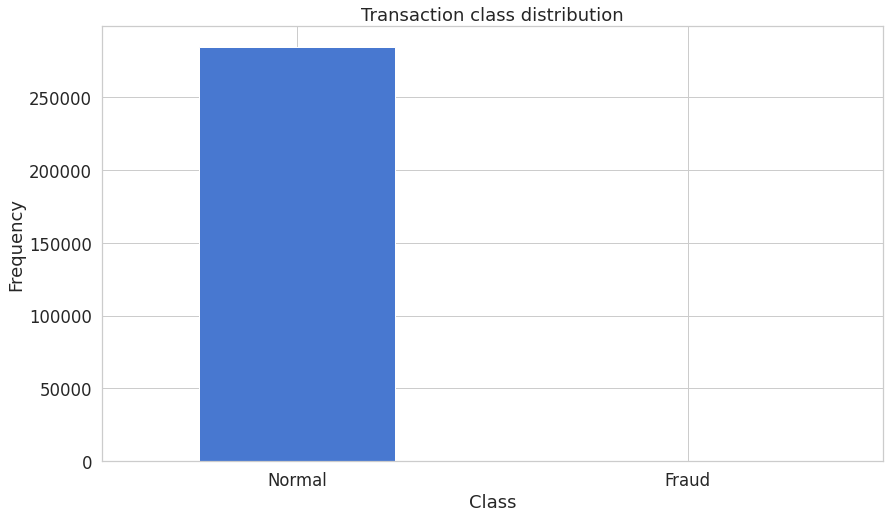

In [11]:
count_classes = pd.value_counts(df['Class'], sort=True) 
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)  # LABELS = ["Normal", "Fraud"]
plt.xlabel("Class")
plt.ylabel("Frequency");

우리는 상당히 불균형한 데이터를 가지고 있습니다. 정상 거래가 이상 거래에 비해 압도적으로 많죠.

두 거래 유형에 대해 살펴봅시다.

In [12]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


각 거래 유형의 거래액은 어떻게 다를까요?

In [13]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

좀 더 그래픽적인 요소를 더해봅시다.

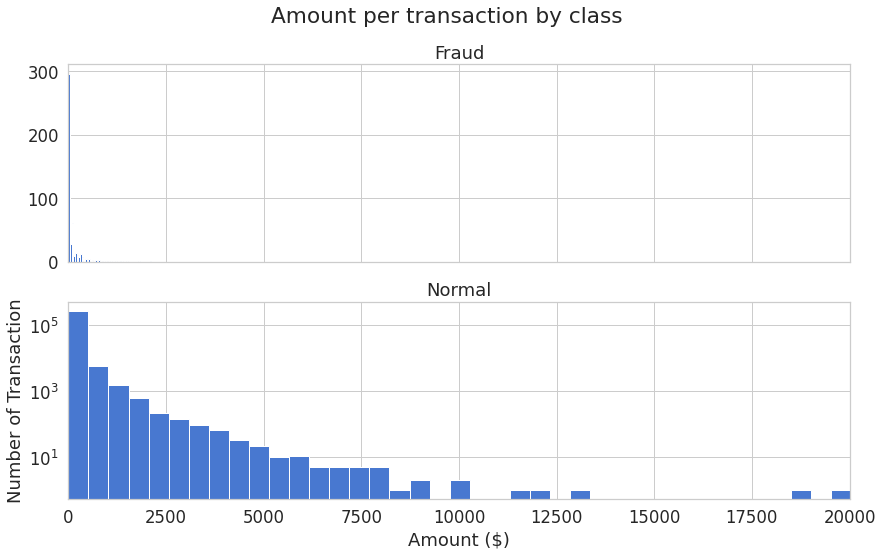

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle("Amount per transaction by class")

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title("Fraud")

ax2.hist(normal.Amount, bins = bins)
ax2.set_title("Normal")

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transaction')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show();

이상 거래가 특정 시간에 더 자주 발생하기도 할까요?

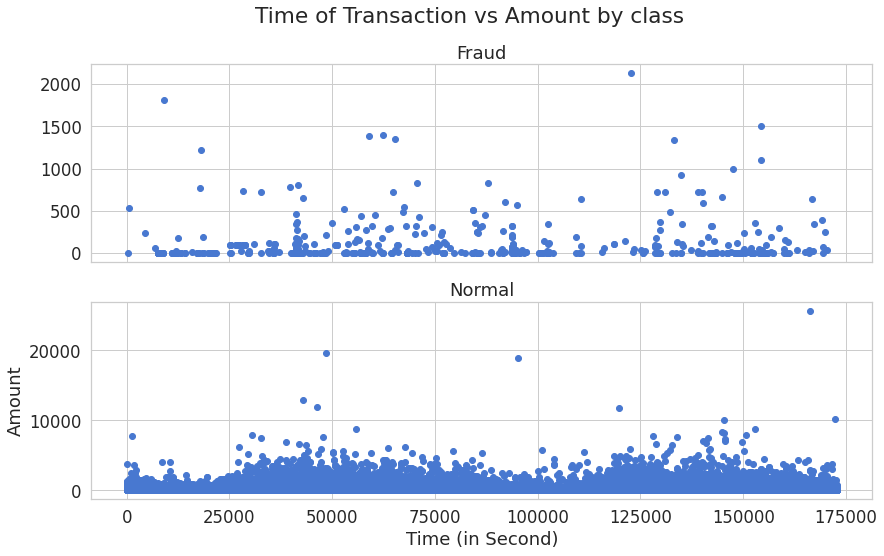

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
fig.suptitle('Time of Transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Second)')
plt.ylabel('Amount')
plt.show()

거래가 발생한 시간이 그렇게 중요한 것 같지는 않아 보입니다.

## Autoencoder
Autoencoder는 처음에는 이상해보일 수도 있습니다. 이러한 모델들은 입력값을 받아서, 입력값을 예측하는 일을 합니다. 어리둥절한가요? 적어도 제가 처음 이 설명을 들었을 때는 그랬거든요.

좀 더 자세히, Autoencoder 신경망에 대해 살펴봅시다. 이 Autoencoder는 다음과 같은 항등 함수를 근사하도록 학습됩니다.
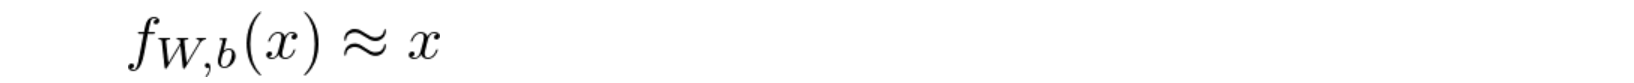


역자 추가 설명:

다음 수학식에서 f는 신경망, W는 가중치(weight), b는 바이어스(bias)입니다.

즉 이 식을 풀어서 설명하자면, 왼쪽에 있는 항은 입력값인 x가 신경망에 들어가는 것을 의미하며, 그 결과가 오른쪽에 있는 x와 같아지도록 근사하는 것을 뜻합니다.

다시 정리하자면 '입력값 x를 받아서 다시 입력값 x를 결과로 뱉어내는 함수'가 바로 Autoencoder 신경망이라는 것이죠.

처음에는 이렇게 하는 것이 대수롭지 않게 보일 수도 있지만, 우리가 특정한 데이터의 압축된 표상(representation)을 학습시키고 그 구조(structure)를 찾고 싶어한다는 점이 중요합니다. 이것은 모델 안에 있는 은닉 유닛(hidden unit)의 수를 제한하는 방법을 통해 가능합니다. 이런 종류의 autoencoder들은 미완성(undercomplete) 이라 불립니다.

여기 Autoencoder의 학습 과정을 시각적으로 표현해보았습니다.

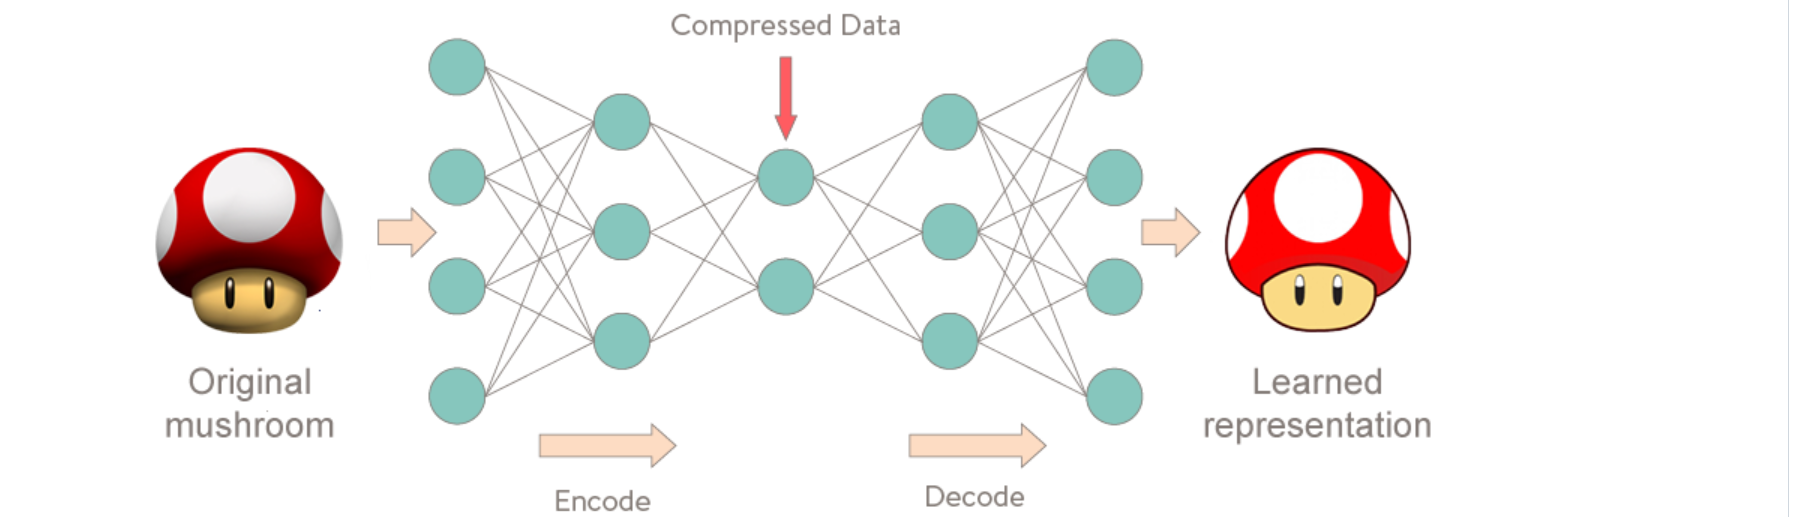

## 재구성 오류(Reconstruction error)

우리는 Autoencoder 모델의 파라미터(parameter)들을 학습 오류가 최소화되도록 최적화시킵니다. 이 때 쓰이는 학습 오류는 조금 특별한 종류인데, 바로 재구성 오류(reconstruction error)입니다. 실전에서는 다음과 같이 전통적인 제곱식으로 오류를 구합니다.

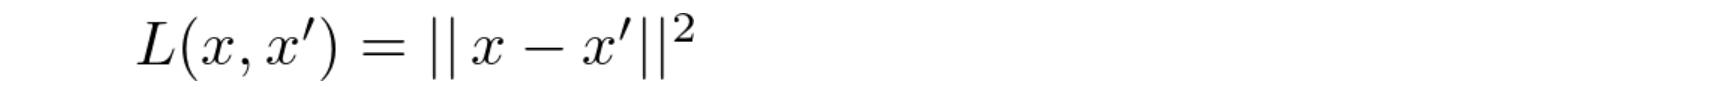img

만약 Autoencoder들에 대해 더 알고 싶다면, Hugo Larochelle의 다음 비디오들을 매우 추천합니다.

[Hugo Larochelle(Autoencoder 동영상)](https://www.youtube.com/watch?v=FzS3tMl4Nsc)

## 데이터 준비
먼저, 시간 열은 쓰지 않을 것이기 때문에 삭제하고 Scikit-learn의 StandardScaler를 거래액 열에 적용해봅시다. StandardScaler는 평균을 제거하고 값들을 단위 분산(unit variance)에 맞게 스케일링해줍니다.

In [19]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Autoencoder를 훈련하는 것은 우리에게 익숙한 방식과는 조금 다릅니다. 우리가 가진 데이터셋 내에 이상이 없는 거래기록이 대부분이라고 가정해봅시다. 그리고 새로운 거래가 생길 때 어떤 이상이 있으면 그것을 탐지해내고 싶다고 합시다. 그렇다면 우리는 모델을 오직 정상 거래기록으로만 훈련시킵니다. 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가할 수 있습니다. 우리는 가진 데이터의 20%를 테스트에 사용할 것입니다.

In [29]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape


(227451, 29)

## 모델 만들기
우리가 만들 Autoencoder는 4개의 fully connected layer로 만들어져 있으며, 각 layer는 14, 7, 7, 29개의 뉴런으로 구성되어 있습니다. 처음 두 개의 layer들은 encoder로 쓰이며, 뒤의 두 개는 decoder가 됩니다. 또, L1 정규화(regularization)를 사용합니다.

In [33]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation='tanh', 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder) 
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)  
decoder = Dense(input_dim, activation='relu')(decoder) 
autoencoder = Model(inputs=input_layer, outputs=decoder)
    

우리가 만든 모델을 100 에폭(epoch) 동안 32의 배치 사이즈(batch size)로 훈련시킨 후, 가장 우수한 성능을 가진 모델을 파일로 저장해봅시다. Keras에서 제공되는 ModelCheckpoint가 이러한 일들을 하는 데 매우 편리합니다. 추가적으로, 훈련 과정은 TensorBoard에 맞는 포맷으로 저장됩니다.

In [35]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verboss=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True, write_images=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.8099 - accuracy: 0.5827 - val_loss: 0.7819 - val_accuracy: 0.6582
Epoch 2/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7401 - accuracy: 0.6689 - val_loss: 0.7631 - val_accuracy: 0.6708
Epoch 3/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7265 - accuracy: 0.6841 - val_loss: 0.7556 - val_accuracy: 0.6852
Epoch 4/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7200 - accuracy: 0.6970 - val_loss: 0.7506 - val_accuracy: 0.6967
Epoch 5/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7164 - accuracy: 0.7028 - val_loss: 0.7478 - val_accuracy: 0.7029
Epoch 6/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7137 - accuracy: 0.7046 - val_loss: 0.7473 - val_accuracy: 0.7055
Epoch 7/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7115 - accuracy: 0.7065 - val_loss: 0.7455 -

KeyboardInterrupt: ignored